Intro:
In this project I will be implementing a GAN or a Generative Adversarial Network. The data consists of about 7,000 - 10,000 Monet-style images provided by the Kaggle compettion *I'm something of a Painter Myself*. The objective is to implement algorithms that are able to generate images similar to the images provided in the data set. Like the description on Kaggle suggests, the objctive is to create a master piece after training the model. 

In [3]:
# Relevant libraries 
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

c:\Users\ere200\Documents\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


There is no difference between the _trfrec and jpg images other than being data formats. Below I define the path to the directories of the dataset. 

In [4]:
# defining the paths to these directories
monet_dir = os.path.join('monet_jpg')
photo_dir = os.path.join('photo_jpg')

#listing all image files below
monet_images = os.listdir(monet_dir)
photo_images = os.listdir(photo_dir)

#printing out the number of images found in the directories
print(f"Number of Monet images: {len(monet_images)}")
print(f"Number of Photo images: {len(photo_images)}")

Number of Monet images: 256
Number of Photo images: 7038


Below we will be pre-processing the data and images. Normalization is performed after decoding of the images and resizing. This is necesary for the neural networks. Resizing ensures that the dimensions are consistent.  

In [5]:
#function to load images and also normalizing the pixels
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image - 127.5) / 127.5  # Normalizing to [-1, 1]
    return image

def load_image_from_folder(folder_path, image_list):
    return [load_image(os.path.join(folder_path, image)) for image in image_list]

monet_images = load_image_from_folder(monet_dir, monet_images)
photo_images = load_image_from_folder(photo_dir, photo_images)


Below I define the generator and disciminator architecture. The generator is designed to transform the input images into the Monet-style images from the dataset. The convolutional layers are for feature extraction and downsampling while the residuals are for perserving information. Upsampling is for generating high resolution images. 

Similarly, the Discriminator is designed to classify whether the images are real or not based off of the dataset. The features are then extracted for binary classification.

In [6]:
import tensorflow_addons as tfa

# Generator is being defined here
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (7, 7), padding='same', input_shape=[256, 256, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tfa.layers.InstanceNormalization())
    
    # Downsampling
    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tfa.layers.InstanceNormalization())
    
    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tfa.layers.InstanceNormalization())

    # Residual Blocks
    for _ in range(9):
        model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tfa.layers.InstanceNormalization())

    # Upsampling
    model.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tfa.layers.InstanceNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tfa.layers.InstanceNormalization())
    
    model.add(tf.keras.layers.Conv2D(3, (7, 7), padding='same', activation='tanh'))

    return model

#Below we define our descriminator
def discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', input_shape=[256, 256, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tfa.layers.InstanceNormalization())

    model.add(tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tfa.layers.InstanceNormalization())
    
    model.add(tf.keras.layers.Conv2D(512, (4, 4), strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tfa.layers.InstanceNormalization())

    model.add(tf.keras.layers.Conv2D(1, (4, 4), padding='same'))

    return model


In [7]:
# Instantiating the generators and discriminators
monet_generator = generator()
photo_generator = generator()
monet_discriminator = discriminator()
photo_discriminator = discriminator()

Below we define functions that calculate the relevant metrics such as losses for the generator and discriminator.
The generator loss quantifies how well the generator can achieve creating an image that is indistinguishable from the real images.

The purpose of the discriminator loss function is to distinguish between real and generated images. Performance is evaulated on real and generated images.

The cycle loss ensures that the egenrated image can be converted back to the original image by perserving the essential features of the input image. 

In [8]:
#function that computes the generator loss
#discrimiator should classify these output images as real.
def generator_loss(disc_generated_output):
    loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(disc_generated_output), disc_generated_output) #MSE for loss
    return loss

#function that computes the discrminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.MeanSquaredError()(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

#function that computes the cycle loss
def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image)) 
    return loss


Below we compile our models and for the sake of time being I only choose 6 epochs. With my laptop it took about 11 hours for my model to complete training.
Gradient computation and application takes place in this code below  and where we ensure the model learns to generate the realistic Monet-style images.

In [17]:
# Compile the model
monet_generator.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), loss='mse')
photo_generator.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), loss='mse')
monet_discriminator.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), loss='mse')
photo_discriminator.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), loss='mse') #Adam adapts learning rate during training

# Training loop 
EPOCHS = 6
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    for monet_image, photo_image in zip(monet_images, photo_images):
        # Adding batch dimension here
        monet_image = tf.expand_dims(monet_image, axis=0)
        photo_image = tf.expand_dims(photo_image, axis=0)
        
        # GradientTape allows us to calculate gradients of the loss functions with
        # respect to model params
        #Most important for improving performance of the GAN
        with tf.GradientTape(persistent=True) as tape:
            fake_photo = monet_generator(monet_image)
            cycled_monet = photo_generator(fake_photo)

            fake_monet = photo_generator(photo_image)  #fake photo being generated
            cycled_photo = monet_generator(fake_monet) #fake photo goes in the cycle

            disc_real_monet = monet_discriminator(monet_image) #outputs for the real and fake images
            disc_real_photo = photo_discriminator(photo_image)
            disc_fake_monet = monet_discriminator(fake_monet)
            disc_fake_photo = photo_discriminator(fake_photo)

            # Calculate the loss
            gen_g_loss = generator_loss(disc_fake_photo)
            gen_f_loss = generator_loss(disc_fake_monet)

            total_cycle_loss = cycle_loss(monet_image, cycled_monet) + cycle_loss(photo_image, cycled_photo)

            # Total generator loss = adversarial loss + cycle loss
            total_gen_g_loss = gen_g_loss + total_cycle_loss
            total_gen_f_loss = gen_f_loss + total_cycle_loss

            disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
            disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

        # Calculate the gradients and apply them
        generator_g_gradients = tape.gradient(total_gen_g_loss, monet_generator.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, photo_generator.trainable_variables)
        discriminator_monet_gradients = tape.gradient(disc_monet_loss, monet_discriminator.trainable_variables)
        discriminator_photo_gradients = tape.gradient(disc_photo_loss, photo_discriminator.trainable_variables)

        # Gradients are applied for the generatos and discriminators
        monet_generator.optimizer.apply_gradients(zip(generator_g_gradients, monet_generator.trainable_variables))
        photo_generator.optimizer.apply_gradients(zip(generator_f_gradients, photo_generator.trainable_variables))
        monet_discriminator.optimizer.apply_gradients(zip(discriminator_monet_gradients, monet_discriminator.trainable_variables))
        photo_discriminator.optimizer.apply_gradients(zip(discriminator_photo_gradients, photo_discriminator.trainable_variables))

    print(f"Epoch {epoch+1}/{EPOCHS} completed")


Epoch 1/6
Epoch 1/6 completed
Epoch 2/6
Epoch 2/6 completed
Epoch 3/6
Epoch 3/6 completed
Epoch 4/6
Epoch 4/6 completed
Epoch 5/6
Epoch 5/6 completed
Epoch 6/6
Epoch 6/6 completed


It took about 11 hours for our model to complete its training and next we will plot out our generated images.

In [19]:
from PIL import Image
import numpy as np

# Creating the directories to save the results
os.makedirs('generated_monet_images', exist_ok=True)
os.makedirs('generated_photo_images', exist_ok=True)

# Function to denormalize images since we did this in the intial stages
def denormalize_image(image):
    image = image * 127.5 + 127.5  # the images were normalized to [-1, 1]
    return np.clip(image, 0, 255).astype(np.uint8)

# Only generating to waste much time
num_images_to_generate = 10

# Here we generate Monet-style images from photos
for i, photo_image in enumerate(photo_images[:num_images_to_generate]):
    photo_image = tf.expand_dims(photo_image, axis=0)
    generated_monet_image = monet_generator(photo_image)
    generated_monet_image = tf.squeeze(generated_monet_image, axis=0).numpy()
    generated_monet_image = denormalize_image(generated_monet_image)
    Image.fromarray(generated_monet_image).save(f'generated_monet_images/monet_{i+1}.jpg')

# Generate photo-style images from Monet paintings
for i, monet_image in enumerate(monet_images[:num_images_to_generate]):
    monet_image = tf.expand_dims(monet_image, axis=0)
    generated_photo_image = photo_generator(monet_image)
    generated_photo_image = tf.squeeze(generated_photo_image, axis=0).numpy()
    generated_photo_image = denormalize_image(generated_photo_image)
    Image.fromarray(generated_photo_image).save(f'generated_photo_images/photo_{i+1}.jpg')

print("Generated images have been saved.")


Generated images have been saved.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


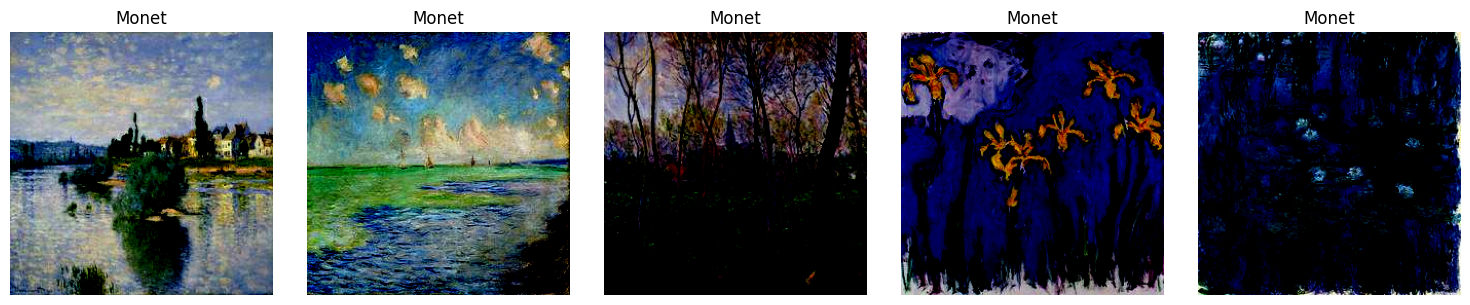

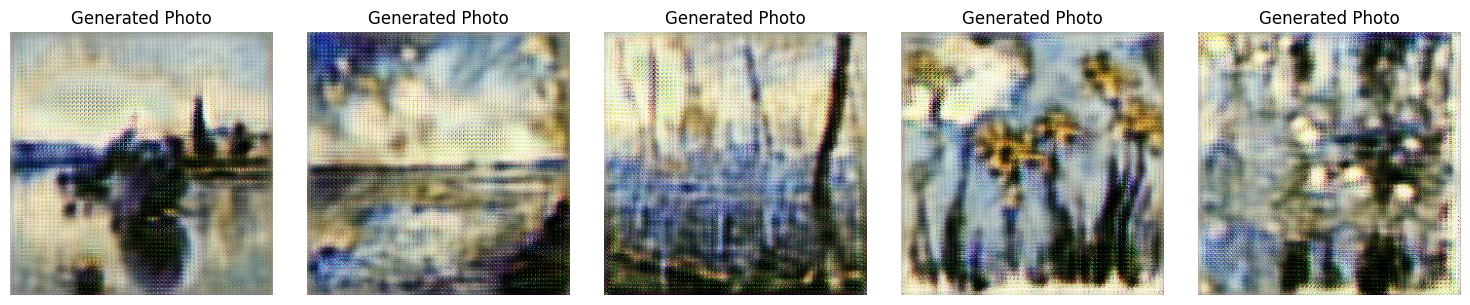

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


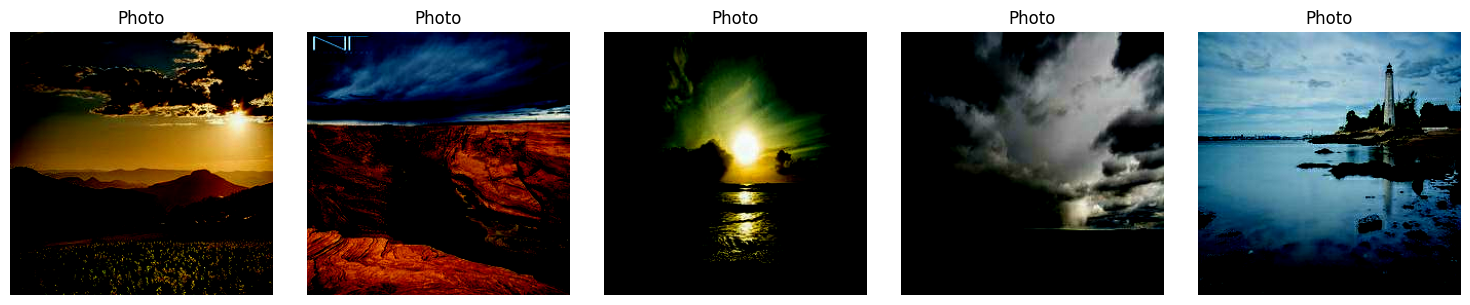

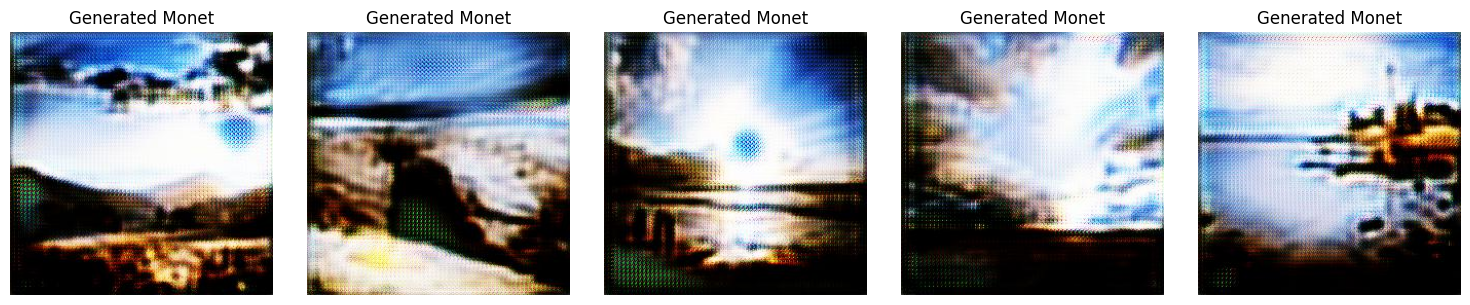

In [20]:
# Function to display images
def display_images(images, titles, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i % cols] if rows == 1 else axes[i // cols, i % cols]
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display a few original and generated images
sample_monet_images = [monet_images[i] for i in range(5)]
sample_generated_photo_images = [Image.open(f'generated_photo_images/photo_{i+1}.jpg') for i in range(5)]
sample_photo_images = [photo_images[i] for i in range(5)]
sample_generated_monet_images = [Image.open(f'generated_monet_images/monet_{i+1}.jpg') for i in range(5)]

display_images(sample_monet_images, ["Monet"] * 5)
display_images(sample_generated_photo_images, ["Generated Photo"] * 5)
display_images(sample_photo_images, ["Photo"] * 5)
display_images(sample_generated_monet_images, ["Generated Monet"] * 5)


Epoch 1/4
Epoch 1/4 completed
Epoch 2/4
Epoch 2/4 completed
Epoch 3/4
Epoch 3/4 completed
Epoch 4/4
Epoch 4/4 completed


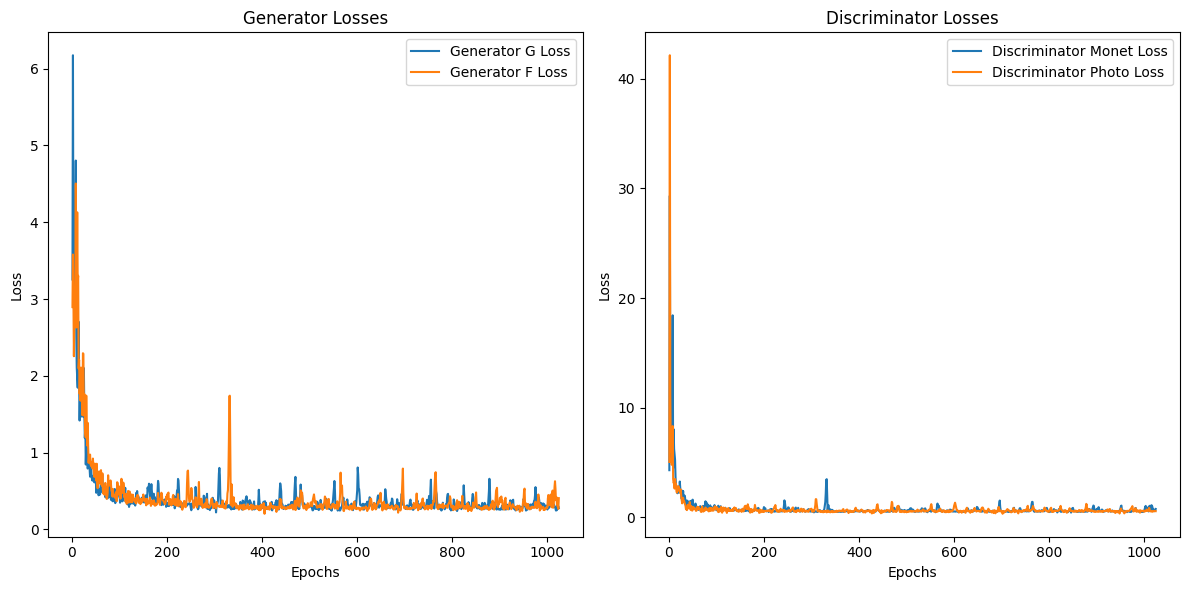

In [9]:
# Initializing lists to store losses
gen_g_losses = []
gen_f_losses = []
disc_monet_losses = []
disc_photo_losses = []

# Compile the model
monet_generator.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), loss='mse')
photo_generator.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), loss='mse')
monet_discriminator.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), loss='mse')
photo_discriminator.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), loss='mse')

# Training loop
EPOCHS = 4
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    for monet_image, photo_image in zip(monet_images, photo_images):
        # Add batch dimension
        monet_image = tf.expand_dims(monet_image, axis=0)
        photo_image = tf.expand_dims(photo_image, axis=0)
        
        with tf.GradientTape(persistent=True) as tape:
            fake_photo = monet_generator(monet_image)
            cycled_monet = photo_generator(fake_photo)

            fake_monet = photo_generator(photo_image)
            cycled_photo = monet_generator(fake_monet)

            disc_real_monet = monet_discriminator(monet_image)
            disc_real_photo = photo_discriminator(photo_image)
            disc_fake_monet = monet_discriminator(fake_monet)
            disc_fake_photo = photo_discriminator(fake_photo)

            # Calculate the loss
            gen_g_loss = generator_loss(disc_fake_photo)
            gen_f_loss = generator_loss(disc_fake_monet)

            total_cycle_loss = cycle_loss(monet_image, cycled_monet) + cycle_loss(photo_image, cycled_photo)

            # Total generator loss = adversarial loss + cycle loss
            total_gen_g_loss = gen_g_loss + total_cycle_loss
            total_gen_f_loss = gen_f_loss + total_cycle_loss

            disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
            disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

        # Calculate the gradients and apply them
        generator_g_gradients = tape.gradient(total_gen_g_loss, monet_generator.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, photo_generator.trainable_variables)
        discriminator_monet_gradients = tape.gradient(disc_monet_loss, monet_discriminator.trainable_variables)
        discriminator_photo_gradients = tape.gradient(disc_photo_loss, photo_discriminator.trainable_variables)

        monet_generator.optimizer.apply_gradients(zip(generator_g_gradients, monet_generator.trainable_variables))
        photo_generator.optimizer.apply_gradients(zip(generator_f_gradients, photo_generator.trainable_variables))
        monet_discriminator.optimizer.apply_gradients(zip(discriminator_monet_gradients, monet_discriminator.trainable_variables))
        photo_discriminator.optimizer.apply_gradients(zip(discriminator_photo_gradients, photo_discriminator.trainable_variables))

        # Store the losses
        gen_g_losses.append(gen_g_loss.numpy())
        gen_f_losses.append(gen_f_loss.numpy())
        disc_monet_losses.append(disc_monet_loss.numpy())
        disc_photo_losses.append(disc_photo_loss.numpy())

    print(f"Epoch {epoch+1}/{EPOCHS} completed")

# Plot generator and discriminator losses
def plot_losses(gen_g_losses, gen_f_losses, disc_monet_losses, disc_photo_losses):
    epochs = range(1, len(gen_g_losses) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, gen_g_losses, label='Generator G Loss')
    plt.plot(epochs, gen_f_losses, label='Generator F Loss')
    plt.title('Generator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, disc_monet_losses, label='Discriminator Monet Loss')
    plt.plot(epochs, disc_photo_losses, label='Discriminator Photo Loss')
    plt.title('Discriminator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the losses
plot_losses(gen_g_losses, gen_f_losses, disc_monet_losses, disc_photo_losses)


In the plots above we can see that the losses for the generator and dicriminator quickly converge as the number of epochs increase. This time since we ran 4 epochs instead of 6 the compilation and training time was about 7 hours. Yet at the same time based off of the plots of the genertator and discriminator loss we still see what we expect as far as the behavior of the loss goes.

Conclusion: In this project we were able to create our own GAN using Tensorflow and Keras library. We were able to train our model based off of the dataset provided by the Kaggle competition and even generated our own images. The fake images did appear to be similar to that of the Monet-style, but I do think the images were kind of grainy and did not look as realistic. I believe probably letting the model run for more epochs could have improved the quality of the generated images but in the interest of time I decided to not choose that many epochs.